In [0]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
from IPython.core.debugger import set_trace

In [0]:
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import PIL
import torch

# Purpose
This notebook will go through the challenge of applying image matting to the [CelebA dataset](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html).

## What is image matting?
Image matting is essentially fine-grained image segmentation. Image segmentation is all about classifying pixels. The algorithm goes through each pixel in an image, and decides whether it should classify it as for example, a car, a road, a cyclist, a house etc. Datasets like CamVid are all about this.  
An extension, Image Matting is about more fine-grained prediction between foreground and background (just two classes). However, the challenge lies in predicting the alpha, which governs the transparency. To put it more practically, Image Matting is often applied to separate a foreground subject (like a person) from its background, while preserving intricate details like hair strands, nets etc.  
For this challenge, the question more concretely becomes: can I build a network that reliably separates the celebrities from their backgrounds, while respecting the more subtle details like hair strands/wisps etc?

# Getting a feeling for the dataset
I'll briefly explore the CelebA dataset that we will be running image matting on. Given the particular approach I am planning on taking, there won't be a whole lot to explore, but getting a general feeling of what's in a dataset is always a good idea.

## Dataset contents
The dataset contains ~200k center-aligned pictures of 10k celebrities in various poses and environments. They also include a couple of CSV files with landmark locations (eyes, nose, lips) and binary attributes (wears_lipstick, beard, attractive). I've quickly scanned through them, but nothing seems of immediate use to image matting:
`5_o_Clock_Shadow`, `Arched_Eyebrows`, `Attractive`, `Bags_Under_Eyes`, `Bald`, `Bangs`, `Big_Lips`, `Big_Nose`, **`Black_Hair`**, `Blond_Hair`, `Blurry`, `Brown_Hair`, `Bushy_Eyebrows`, `Chubby`, `Double_Chin`, `Eyeglasses`, `Goatee`, `Gray_Hair`, `Heavy_Makeup`, `High_Cheekbones`, `Male`, `Mouth_Slightly_Open`, `Mustache`, `Narrow_Eyes`, `No_Beard`, `Oval_Face`, `Pale_Skin`, `Pointy_Nose`, `Receding_Hairline`, `Rosy_Cheeks`, `Sideburns`, `Smiling`, `Straight_Hair`, `Wavy_Hair`, `Wearing_Earrings`, **`Wearing_Hat`**, `Wearing_Lipstick`, `Wearing_Necklace`, `Wearing_Necktie`, `Young`  
There's two attributes that I've highlighted that I'm a bit concerned over as they might end up confusing the algorithm (different head shape, or hard to distinguish from background) but there isn't a lot I can do about them just now.

The dataset also includes bounding boxes which seemed interesting at first, but this is just the bounding box of the cutout from the original image, not a bounding box of the celebrity itself.

## Particular things to look out for
As mentioned above, image matting is about separating foregrounds from backgrounds. This is the easiest when the background and foreground contrast sharply in color. My main question will be to get a feeling for whether the dataset contains mostly contrasting foregrounds and backgrounds, which will most likely have the most significant impact on performance.

In [0]:
from fastai import *
from fastai.vision import *

In [0]:
celeba_path = Path(f"{data_dir}/celeba-sample/celeba")
celebs = get_image_files(celeba_path)
celebs[:3]

[PosixPath('/content/gdrive/My Drive/fastai-files/aisegment/test3/celeba-sample/celeba/000608.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-files/aisegment/test3/celeba-sample/celeba/000634.jpg'),
 PosixPath('/content/gdrive/My Drive/fastai-files/aisegment/test3/celeba-sample/celeba/000152.jpg')]

In [0]:
def plot_image_array(rows=2, cols=3, figure_size=10, offset=0):
    f, ax = plt.subplots(rows,cols)

    f.set_figheight(figure_size)
    f.set_figwidth(figure_size)
    curr_row = 0

    for i in range(rows*cols):
        image = PIL.Image.open(celebs[offset+i])
    
        col = i%rows
        ax[col, curr_row].imshow(image)
        ax[col, curr_row].axis('off')
    
        if col == rows-1:
            curr_row += 1

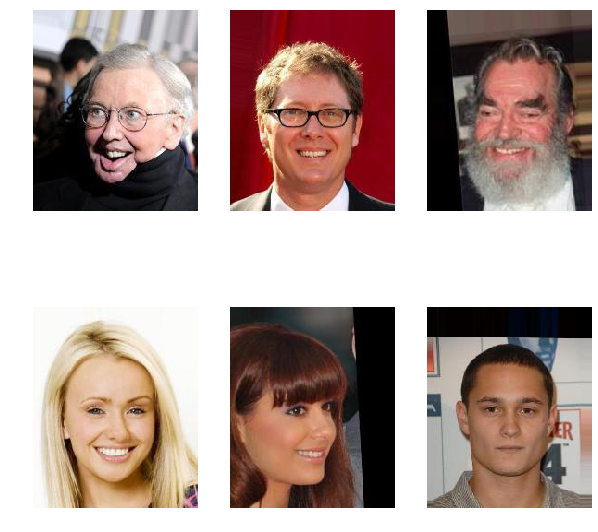

In [0]:
plot_image_array()

That doesn't look so bad, let's try another batch...

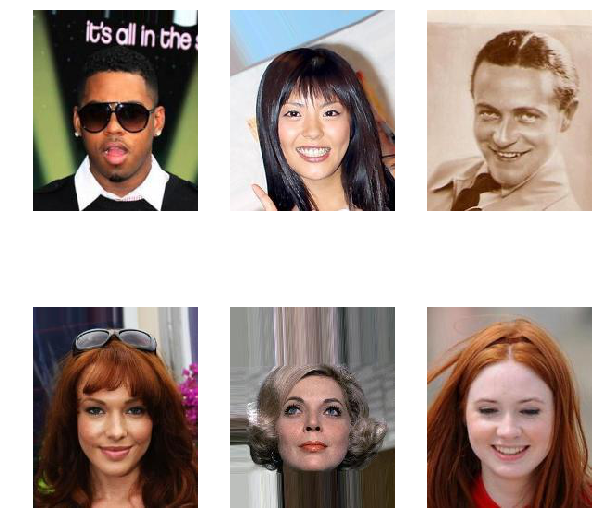

In [0]:
plot_image_array(offset=10)

Two observations:  
* We can see a really good challenge for the network in the first picture. Black hair, black background. As a human I wouldn't know how to mat this though I know it's probably short-cropped hair. It'll be interesting to see what the algorithm comes up with.
* There's a sepia coloration at `[1,3]`. The network I build should probably rely more on structural changes than on coloration changes to perform matting.
* I have no idea what's happening in the picture at `[2,2]` but I'll give my network a free pass on that one, what the hell...

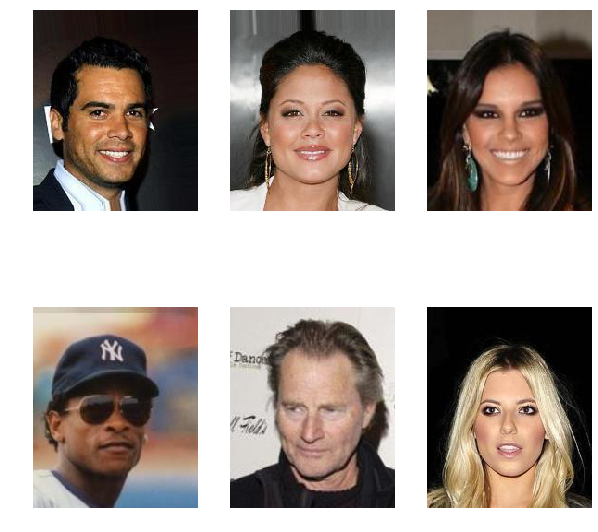

In [0]:
plot_image_array(offset=20)

From this first pass, I'm not really seeing anything that I can immediately affect or use to my advantage. As suspected above, a few of the celebrity pictures have dark hair on a dark background (according to the binary labels, ~25% of the dataset images have black hair in general). That's just really hard to mat, even for a human with great Photoshop skills (the CelebA JPG images are about 10KB in size on average, that's not a whole lot of information depth to go on). The hats are also a challenge, but again, there's nothing I can immediately do about it. If it turns out this is really a performance breaker, a possible solution could be to add more hat-wearers to the training datasets. There's only ~10k hat-wearer images in the datasets though, constituting 0.5% so that's overseeable.

# State of the art in image matting
There's quite a few papers on the practice of image matting out there, but two caught my eye.

## Deep Image Matting by Xu et al (Adobe)
This paper from 2017 ([arXiv:1703.03872](https://arxiv.org/abs/1703.03872) \[cs.CV]) will drive most of my design choices. Strictly, it implements "human-aided" segmentation as the proposed network takes in an RGBA image, where the alpha channel is a trimap. It then feeds it through a U-net with VGG16 as an encoder, and after the decoder stage, passes it through a couple of convolutional layers to "refine" the alpha predictions. What's nice is that the architecture specifically focuses on structural context, not on coloration changes, which is what I'll need, as discussed above.

## Semantic Human Matting by Chen et al (Ali Baba)
This second paper from 2018 ([arXiv:1809.01354 [cs.CV]](https://arxiv.org/abs/1809.01354)) takes a non-assisted approach, it uses no human-generated trimaps. Instead, it chains a segmentation network (PSPNet-50, which creates a trimap-like raw alpha) with a U-net (also with a VGG16 encoder) to produce the final alpha predictions. 

## Approach
It looks like while the overall network architecture varies a bit, both rely on a first stage of segmentation which is followed by a U-net with a ImageNet pretrained VGG16 encoder.

I'll essentially be re-implementing the DIM paper using fastai. I'll deviate in two ways:
* I don't have trimaps for CelebA, so I will first build a U-net based trimap generator (an architecture which is generally used for segmentation tasks as shown by the papers above)
* For the U-nets, I'll use a pretrained ResNet34 encoder instead of VGG16. This is a relatively significant change, and I suspect it will hurt the quality of my predictions quite a bit (I'm assuming there's a good reason a 2018 paper with fantastic results uses VGG not ResNet). However, I'm limited by the constraints of Google's Colab, which most importantly limits any given runtime to maximum ~12 hours of continuous operation. ResNet runs faster while still being a decent encoder and it's readily available in my frameworks of choice, so it'll be my choice for this particular environment. Were these constraints non-existent, I'd use VGG16 because I suspect it would produce better results. Sadly the papers provide no reasoning on why they use VGG16 over other architectures.

I've chosen not to take the SHM paper approach as I don't have a PSPNet implementation lying around, and even if I did, E2E training of that whole model is unlikely to fit at a reasonable pace on the Colab GPUs.

## Framework: fastai v1 + pyTorch
I've read quite some griping online with respect to the fastai library. Most criticism seems to center around the fact that fastai does a _lot_ to abstract things away from its users. This should come as no surprise: this is the explicit mission the developers of the framework have in mind.  
I agree that it abstracts away a lot, and I've found myself digging around the source code very frequently, so I partially resonate with the skepticism. However, they've worked hard on improving that (though there's still a long way to go, looking at you `transformer` and `Callback` documentation).

I've used the fastai framework for two reasons:
* It's the one I'm most familiar with
* You get a lot of sane defaults and useful factory methods out of the box (think image transformation, data loader setup etc), which means I can get to work faster (mostly anyways)

It also allowed me to get a more gentle introduction to pyTorch.

# Trimap Generation
The trimap generation network will take as an input an RGB image and should output a trimap. I've used the [SegmentAI dataset](https://www.kaggle.com/laurentmih/aisegmentcom-matting-human-datasets) along with [OpenCV's dilate and erode](https://docs.opencv.org/3.4/db/df6/tutorial_erosion_dilatation.html) to generate a training-set of trimaps out of the alphas provided by the AISegment dataset. We'll use a default U-net (a standard choice for image segmentation tasks, see the most recent [Carvana Kaggle winner paper](https://arxiv.org/abs/1801.05746), which also uses VGG!) to predict the 3 classes: background, uncertain, foreground.

In [0]:
from fastai import *
from fastai.vision import *
from fastai.torch_core import *

Setting up the data directories.

In [0]:
img_path = Path(f"{data_dir}/320/patch")
lbl_path = Path(f"{data_dir}/320/trimaps")
imgs = get_image_files(img_path)
lbls = get_image_files(lbl_path)
assert(len(imgs) == len(lbls))

## Trimap loss function
I'm subclassing the standard Cross Entropy loss because of two reasons:
* I'm making sure the `__init__()` has default `axis=int:-1`
* I'm making sure the `__call__()` converts the target to `long()` (default ingestion of the trimap is `float()`).  

Aside from those minor edits it's just the standard `FlattenedLoss` from fastai. We'll feed it the `toch.nn.CrossEntropyLoss` (the actual loss function) at a later stage, which is the default for multi-class image segmentation.

In [0]:
class CustomFlattenedLoss(FlattenedLoss):
    def __init__(self, func, *args, axis:int=1, floatify:bool=False, is_2d:bool=True, **kwargs):
        self.func,self.axis,self.floatify,self.is_2d = func(*args,**kwargs),axis,floatify,is_2d
        functools.update_wrapper(self, self.func)
        
    def __call__(self, input:Tensor, target:Tensor, **kwargs):
        input = input.transpose(self.axis,-1).contiguous()
        target = target.transpose(self.axis,-1).contiguous()
        if self.floatify: target = target.float()
        input = input.view(-1,input.shape[-1]) if self.is_2d else input.view(-1)
        return self.func.__call__(input, target.view(-1).long(), **kwargs)


## Data source setup
My trimaps have values ranging between 0 and 255 (more specifically, 0 for background, 127 for uncertain, 255 for foreground) but these values don't play nicely with the standard `nn.CrossEntropyLoss`. Conversely, dividing by 255 results in all kinds of floating points nastyness.  
To avoid both, I just replace the 127 and 255 with 1s and 2s which solves the issue. It does mean I have to subclass `SegmentationLabelList` to pass it a different `open()` method. However, that's to my benefit as I need to feed it the custom loss `CustomFlattenedLoss` anyways.

In [0]:
def round_open_image(fn:PathOrStr, div:bool=True, convert_mode:str='RGB', cls:type=Image,
        after_open:Callable=None)->Image:
    "Return `Image` object created from image in file `fn`."
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", UserWarning) # EXIF warning from TiffPlugin
        x = PIL.Image.open(fn).convert(convert_mode)
        x = x.point(lambda x: 1 if x is 127 else x)
        x = x.point(lambda x: 2 if x is 255 else x)
    if after_open: x = after_open(x)
    x = pil2tensor(x,np.float32)
    if div: x.div_(255)
        
    assert(np.array_equal(np.unique(x.numpy()), np.array([0,1,2])))
    return cls(x)

class CustomSegmentationLabelList(SegmentationLabelList):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.loss_func = CustomFlattenedLoss(torch.nn.CrossEntropyLoss)
        
    def open(self, fn): return round_open_image(fn, convert_mode='L', div=False)
    

class CustomSegmentationItemList(SegmentationItemList):
    _label_cls = CustomSegmentationLabelList

In [0]:
def get_y_fname(filename):
    return lbl_path/f"{filename.stem}.png"

In [0]:
codes = np.array(['background', 'uncertain', 'foreground'], dtype=str)

In [0]:
src = (CustomSegmentationItemList.from_folder(img_path)
       .split_by_rand_pct(0.2, 42)
       .label_from_func(get_y_fname, classes=codes)
      )

It'd be better for my batchnorm layers (we'll see them later in the resnet encoder) if I could afford a bigger batch size, but the U-net's a pretty chunky piece of work, bumping the batch size up to 16 throws CUDA OOM errors.  
I'm setting the `p_lighting`, the probability to apply a lighting transformation, to 0 as it modifies my trimaps' values away from 0, 0.5 and 1 (because I have `tfm_y=True`). I'm also normalising with `imagenet_stats` as I'll be using the default pretrained `resnet34` encoder.

In [0]:
bs = 8 # batch size
data = (src.transform(get_transforms(p_lighting=0.), tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

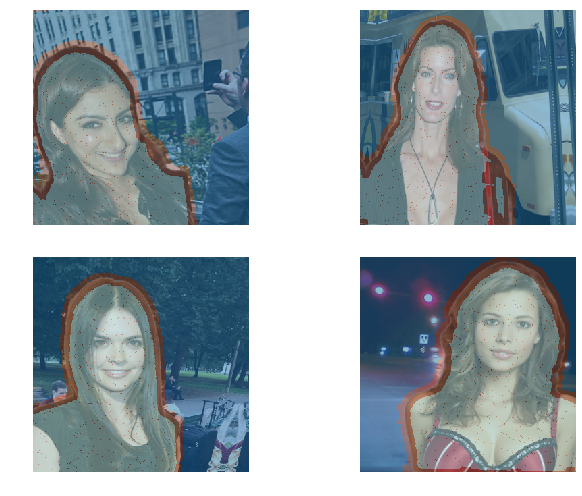

In [0]:
data.show_batch(2, figsize=(10,7))

It's fairly noticeable that our trimaps seem to have some kind of 'measles', i.e. there's little red dots all over our foreground subjects. I suspect this is because my training dataset isn't perfect: the subjects sometimes have an alpha that isn't quite 255, but maybe 240. This isn't quite visible if you plot the alpha itself, but our erosion filter is going to pick up on it and turn all of those into uncertainty areas.  
It's frustrating, but I don't think it's a showstopper: the algorithm still focuses on getting the outlines right. 

**Digression:** I could try to figure out how to write my own CV2 convolution as a preprocessor: it would run a 3x3 or 5x5 kernel over the image. If the anchor point value is below 255, but it is surrounded by 255 values, it would simply "pull up" the pixel's value to 255. It's essentially a dilation filter, but only when surrounding values are 255. I'm unfamiliar with CV2 though, and it seemed beyond the scope here. It may be a good fine-tuning step though.

## Train the trimap generator

Keeping the optimiser's weight decay at a fairly low level as training U-nets is pretty unstable.

In [0]:
wd=1e-2

That's it! We can train the model now. We'll use `unet_learner()` to get a typical U-net model, passing it the encoder we want.

In [0]:
learn = unet_learner(data, models.resnet34, wd=wd)

Run a couple of epochs to find a learning rate where the loss is the steepest...

In [19]:
learn.lr_find()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


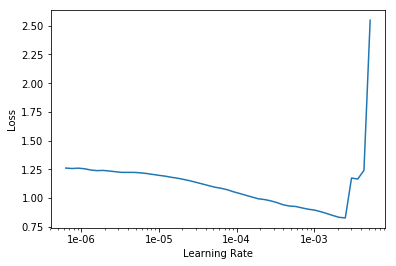

In [20]:
learn.recorder.plot()

In [0]:
lr = 1e-5

Training takes quite some time, at 1200 images, epochs range between 2-5 minutes (depending on how much Colab is getting loaded at the moment). For 12 000 images, we're already up to 20 minutes per epoch. Additionally, we're losing quite some time on the first epoch (1.5 hours instead of 20 minutes) as I suspect behind the scenes, Colab first copies the data from Drive to its local runtime before feeding it to the GPU. Additionally,, I think Colab's CPU's are choking pretty hard on the batch size of 8.  
The researchers use training sets that are ~30-40k images large. I can't imagine the ungodly GPU rigs and budgets they have, but it's outside of what I have access to (aside from spinning up my own instances on AWS/GCP but that's outside of my budget for now).

In [22]:
learn.fit_one_cycle(10, lr, pct_start=0.3)

epoch,train_loss,valid_loss,time
0,0.231038,0.191477,1:32:30


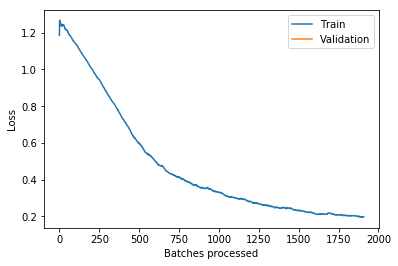

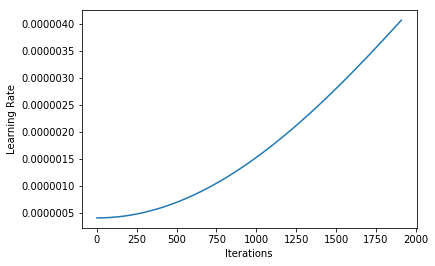

In [23]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

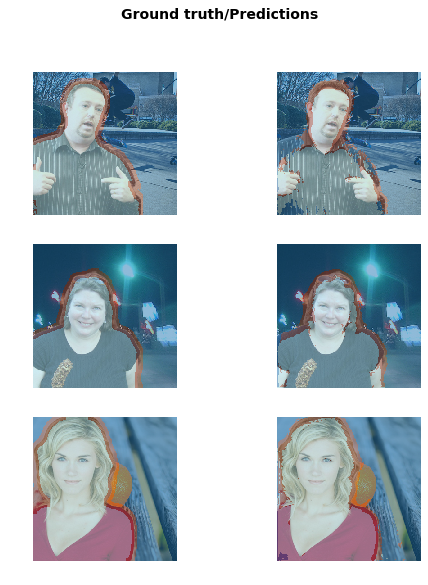

In [24]:
learn.show_results(rows=3, figsize=(8,9))

A good start! I've further trained this trimap generator in a different notebook, the results above are just for demonstration purposes.

## Creating CelebA Trimaps
Now that I've created a model that can generate trimaps, I'll apply it to a sample of CelebA so I can later on feed it into the DIM network.

In [0]:
from fastai.vision.image import image2np
from PIL import Image as PILImage
from matplotlib.pyplot import imshow

In [0]:
src = (CustomSegmentationItemList.from_folder(img_path)
       .split_by_rand_pct(0.2, 42)
       .label_from_func(get_y_fname, classes=codes)
      )

# Adding the celebs
items = src.x.__class__.from_folder(f"{data_dir}/celeba-sample/celeba")
src = src.add_test(items.items, label=None)

bs = 8 # batch size
data = (src.transform(([],[]), tfm_y=False)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

data.c = 1

In [0]:
# Loading model weights from previous training
_ = learn.load('unfrozen_trimap')
learn.data = data

In [0]:
save_path = f"{data_dir}/celeba-sample"
learn.model.training = False

os.makedirs(f"{save_path}/rgb-trimap", exist_ok=True)
save_dir = Path(f"{save_path}/rgb-trimap")

for idx, (inputs, targs) in enumerate(learn.data.test_dl):
    mean, std = torch.tensor([0.485, 0.456, 0.406]).cpu(), torch.tensor([0.229, 0.224, 0.225]).cpu()
    trimaps = learn.pred_batch(batch=(inputs, targs))

    inputs = inputs.cpu()
    # De-normalise the images
    inputs = inputs * std[..., None, None] + mean[:, None, None]
    bs = trimaps.shape[0]
    
    for idx2, batch_num in enumerate(range(bs)):

        trimap = image2np(trimaps[batch_num].argmax(dim=0).unsqueeze(0)).astype(np.uint8)
        patch = image2np(inputs[batch_num,:] * 255).astype(np.uint8)
        
        assert(len(trimap.shape) == 2)
        assert(len(patch.shape) == 3)
        
        trimap = PIL.Image.fromarray(trimap).convert('L')
        patch = PIL.Image.fromarray(patch)

        patch.putalpha(trimap)

        filenumber = str(idx*bs + idx2)
        
        patch.save(f"{save_dir}/{filenumber}.png")

In [0]:
def show(img):
    imshow(np.asarray(img))

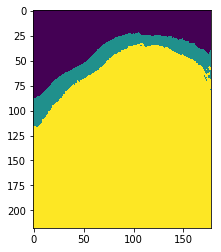

In [0]:
show(trimap)

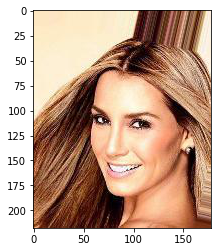

In [0]:
# Remove alpha layer so we can see full image
show(patch.convert('RGB'))

# Deep Image Matting re-implementation

## Custom Loss Function

The loss function for DIM is not that complicated, it's just the alpha loss. Realistically, it's almost the same as the MSE (Mean Squared Error) offered by pyTorch. I just wanted to get a feeling for what it's like to implement a loss function for myself, and torch's nn.MSELoss didn't have the epsilon that the paper mentions as far as I could tell.  
The rest of the code here is just plumbing to be able to nicely call the loss function.

In [0]:
from torch.nn import MSELoss
from torch import Tensor
from fastai.layers import *
from fastai.torch_core import *

In [0]:
class CustomAlphaLossFlat(MSELoss):
    def forward(self, input, target):
        
        # The end of the forward pass gives us two outputs
        pred_alpha, trimap = input
        
        # Only calculate loss in trimap uncertainty area, zero out everything else
        pred_alpha[trimap != 0.5] = 0
        target[trimap != 0.5] = 0
        
        epsilon = 10**-6 # According to paper
        
        # http://openaccess.thecvf.com/content_cvpr_2017/papers/Xu_Deep_Image_Matting_CVPR_2017_paper.pdf
        loss = torch.sqrt((pred_alpha-target) ** 2 + epsilon**2).sum()
        
        # Dividing by batch size so I get a per-image loss
        # This makes the loss interpretable regardless of batch size
        return loss/target.shape[0]
      
class AlphaFlattenedLoss(FlattenedLoss):
    # Subclassing __call__() because it "rolls out" the tensors
    # and my loss function wouldn't know how to deal with that
    def __call__(self, input:Tensor, target:Tensor, **kwargs)->Rank0Tensor:
        return self.func.__call__(input, target, **kwargs)

In [0]:
def custom_AlphaLossFlat(*args, axis:int=-1, floatify:bool=True, **kwargs):
    return AlphaFlattenedLoss(CustomAlphaLossFlat, *args, axis=axis, floatify=floatify, is_2d=False, **kwargs)

## Setting up src and data
This section isn't terribly interesting from an ML perspective. A lot of subclassing is going on, but that's really just because I want to modify the way my images are represented. These fastai classes were all designed with image _segmentation_ in mind, which mostly does what I need it to, except for a few things (like how it's displayed in Jupyter), which I modify here.  
Safe to skip reading this section or just skim.

In [0]:
from fastai.vision.image import *
from fastai.vision.data import *

I'm subclassing the `Image` and `ImageSegment` classes from fastai because it doesn't handle them in the correct way for my cases. The default color maps are destined for segmentation, but it `gray` works better when we're looking at Image Matting.  


---

#### Modifying how the labels are shown
The float representation states now also become important. fastai's default returns the image as a long tensor, but our data is all scaled between 0 and 1. Took me a while to figure out why this wasn't working and stack trace through the code to see where the `tensor.long()` kept coming from.

In [0]:
class AlphaImageSegment(ImageSegment):     
    def show(self, *args, title=None, cmap=None, alpha=None, **kwargs):
        "Show the `ImageSegment` on `ax`."
        ###
        cmap = "gray"
        alpha = 0.6
        ###
        ax = show_image(self, *args, cmap=cmap, alpha=alpha, **kwargs)
        if title: ax.set_title(title)
            
    @property
    def data(self)->TensorImage:
        # DO NOT RETURN AS A LONG TENSOR damnit
        # Important for loss function
        return self.px

I again need a custom `open()` function. The way I'm loading in the alpha is more of an implementation detail (artefact from how I trained the Matting Net separately), but notice that it returns an `AlphaImageSegment` which is important.

In [0]:
def open_alpha(filename):
    label = torch.load(filename)[0:1,:]
    label = label.type(torch.FloatTensor)
    return AlphaImageSegment(label)

Again, subclassing the label list to set our custom loss function, and making sure it opens the images with the custom classes I defined.

In [0]:
class AlphaLabelList(ImageList):
    def __init__(self, items:Iterator, **kwargs):
        super().__init__(items, **kwargs)
        self.loss_func = custom_AlphaLossFlat()
        
    def open(self, fn): return open_alpha(fn)    
    
    def reconstruct(self, t:Tensor): 
       return AlphaImageSegment(t)

#### Modifying how the inputs are shown

Here too, I'm making sure that when I call `show()` on an input, I don't get the trimap as well. This is because i'll be overlaying the inputs with the predicted outputs/alphas, and it will be useful for interpretation to see the entire image (the trimap would cause the background to be rendered as white and only show the foreground + uncertainty region).

In [0]:
class AlphaImage(Image):
    def show(self, *args, **kwargs):
        self.px = self.px[0:3,:]
        super().show(*args, **kwargs)

Same as above, subclassing to make sure it returns the custom `Alpha`-based Image and LabelList.

In [0]:
class DIMImageList(ImageList):
    """
    Have it generate labels based on the tensors we stored (DIMLabelList)
    """
    
    _label_cls,_square_show_res = AlphaLabelList,False
    
    def open(self, fn):
        "Open image in `fn`, subclass and overwrite for custom behavior."
        return open_image(fn, convert_mode=self.convert_mode, after_open=self.after_open, cls=AlphaImage)
    
    def reconstruct(self, t:Tensor): return AlphaImage(t.float().clamp(min=0,max=1))

### Setting up the data source
I've already preprocessed the images to all be of dimension 320x320. The training of this model is already slow, if I'm going to ask fastai to resize arbitrary images on the fly for the transforms (which it does on the CPU), it will slow to a crawl. Additionally, it doesn't play so nice with arbitrary dimensions.  
It's worth noting that I'm setting a seed for the `split_by_rand()` function here (a seed of 42 in the case below). I'm doing this because it allows me to compare the outcomes of the notebooks across instances. Said differently: by setting the same seed everytime, I will get the same images for example when I call `learn.show_results()` at the end of this notebook. That allows me to visually compare between the same images across models.  

In [0]:
filesize = 320
images_path = Path(f"{data_dir}/{filesize}/patch")

def get_y_fname(filename): return Path(f"{data_dir}/{filesize}/label/{filename.stem}.pt")

src = (DIMImageList.from_folder(images_path, convert_mode='RGBA')
      .split_by_rand_pct(0.2, 42)
      .label_from_func(get_y_fname)
      )

Assertions are really unit tests, and they're a fantastic way to avoid bugs 
from occurring. I'm not going to write at length on why unit tests are essential, but this is a reminder to myself that I should be using `assert()` **way** more often, could've saved me countless hours.

In the situation below, I'm making sure that all the pixels of a given `x` image have a value between 0 and 1 for all channels in their RGBA set.  
I'm also asserting that the top-left pixel of the alpha has value 0. That's a bit of a guess, but I'm matting humans, and it's unlikely the alpha will reach the utmost top left pixel.

In [0]:
x = src.x[0].px
    
# Alpha testing, top left pixel should be 0
assert(x[3,0,0] == 0)

# Full image testing
assert(np.amin(x.numpy()) >= 0.)
assert(np.amax(x.numpy()) <= 1.)

Of course I'm also testing the labels.

In [0]:
imagetensor = src.y[0].px
assert(len(imagetensor.shape) == 3) # Make sure it's a 3-dimensional tensor
assert(imagetensor.shape[0] == 1) # Make sure it only has 1 channel
assert(np.amax(imagetensor.numpy() <= 1.)) # Make sure there's no values above 1
assert(np.amin(imagetensor.numpy() >= 0.)) # Make sure there's no values below 0

## Setting up the transforms
There are two custom transforms I will have to add.

**Trimap generation**:  
The data loader opens the `x` image, which has RGBA channels. For the training set, the A channel is actually an alpha, so we'll need to convert it to a trimap first. I need to make sure it is first in the order of transformations, by setting a very early order.  
I'm applying a bit of a hack here with the `_round` variable. It "pulls up" all alpha values >= 0.97 to 1. The reason for this is as I previously mentioned with the 'measles' effect we were seeing in the trimap generation stage above. The value of `_round` was guesstimated from experimentation.

**Trimap normalisation**:
The transforms that come out of the box from fastai's `get_transforms()` (specifically the lighting transform) will modify all pixel values, including the trimap's. Of course, we can't have that, because our loss function relies on the trimap exactly having values 0, 0.5 or 1. To that end, our last transform will normalise the trimap by rounding it back to its nearest stage (0, 0.5 or 1).

In [0]:
from fastai.vision.transform import TfmPixel, get_transforms
from fastai.torch_core import *
import cv2

In [0]:
def _gen_trimap(x, k_range:uniform_int=[1,2]):
    if x.shape[0] == 1:
        # fastai currently ignores use_on_y so need this hack
        # https://github.com/fastai/fastai/issues/2097
        return x
    alpha = x[3].numpy()
    assert(np.amax(alpha) <= 1), "CV2 transforms assume values between 0 and 1"
    _round = 0.03 # Pulling alpha values >= 0.97 up to 1 so they don't cause erosion
    kernel = np.ones((k_range*2+1,k_range*2+1),np.uint8)
    dilate = cv2.dilate(alpha, kernel, iterations=2)
    erode =  cv2.erode( alpha, kernel, iterations=2)
    trimap = np.zeros(alpha.shape,np.float32)
    trimap[alpha  >= (1-_round)] = 1
    trimap[dilate > alpha+_round] = 0.5
    trimap[erode < alpha-_round] = 0.5
    
    # Substituting the alpha layer with a trimap
    x[3] = torch.Tensor(trimap)
    return x
    
# Setting order to -1000 because I want it to be executed first
gen_trimap = TfmPixel(_gen_trimap, order=-1000)

def tfm_wrapper(*args, **kwargs):
    kwargs = {'k_range': [1,2]}
    return gen_trimap(**kwargs, use_on_y=False)

In [0]:
def _norm_trimap(x):
    if x.shape[0] == 1:
        # fastai currently ignores use_on_y so need this hack
        return x
    trimap = x[3].numpy()
    trimap = (trimap*2)
    trimap = np.around(trimap, 0)
    trimap = trimap/2
    x[3] = torch.Tensor(trimap)
    assert((np.asarray(x[3].shape) == np.asarray([320,320])).all())
    return x
    
# Setting order to 1000 because I want it to be executed last
norm_trimap = TfmPixel(_norm_trimap, order=1000)

def norm_wrapper(*args, **kwargs):
    return norm_trimap(**kwargs, use_on_y=False)

Appending the trimap transform and rounding transform to the default transform list. Note that the order in this list is not the execution order, that's set by the `order` kwarg in `TfmPixel()` above.

In [0]:
tfm_trn, tfm_valid = get_transforms()

tfm_trn.append(tfm_wrapper())
tfm_trn.append(norm_wrapper())

tfm_valid.append(tfm_wrapper())
tfm_valid.append(norm_wrapper())

## Setting up the data loader

Normalising with ImageNet stats as we're going to be using the `resnet34` encoder. Notice that the normalisation parameters have an extra dimension, 0 and 1 for mean and std respectively. That's because I don't want the trimap layers to be modified by normalisation.

In [0]:
# Not specifying size as
# image sizes have been pre-processed
bs=8
modified_imagenet_stats = ([0.485, 0.456, 0.406, 0], [0.229, 0.224, 0.225, 1])
data = (src.transform((tfm_trn, tfm_valid), tfm_y=True)
        .databunch(bs=bs)
        .normalize(modified_imagenet_stats))

data.c = 1
data.num_workers=2

### Visual sanity check
Check, check and check again. I can't stress enough how often I should've done this to save myself time debugging.  
I'm checking:
* That all values of `x` are between 0 and 1
* That the trimap has only values 0, 0.5 or 1
* That all values of `y` (the alpha) are between 0 and 1
* That `y` only has 1 channel (the alpha to be predicted)

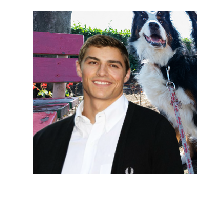

In [0]:
xs, ys = data.one_batch()
batch_index = 0
x = xs[batch_index,0:3,:] # Grab RGB channels
trimap = xs[batch_index,3:4,:] # Grab A channel
alpha = ys[batch_index,0:1,:]

assert(np.array_equal(np.unique(trimap), np.array([0., 0.5, 1.], dtype=np.float32))) # Only 0, 0.5, 1 in trimap
assert(np.amax(x.numpy()) <= 1. and np.amin(x.numpy()) >= 0.)
assert(np.amax(alpha.numpy()) <= 1. and np.amin(alpha.numpy()) >= 0.)
assert(ys[0].shape[0] == 1)

AlphaImage(x).show()

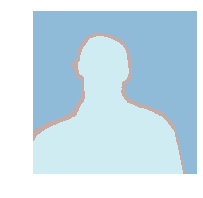

In [0]:
# Multiplying by 2 because matplotlib doesn't assign colors to 0.5
ImageSegment(trimap * 2).show()

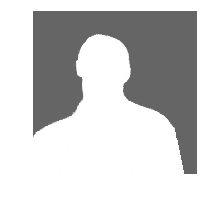

In [0]:
AlphaImageSegment(alpha).show()

## Model Definition
Things get a bit finnicky here because I'm starting to modify things left and right. Let's step through both parts of the `E2EDIM` model.

### __init__()
I need to do two things in the init:
* Our encoder, `resnet34` in this case, has a 3 channel input, but I need it to take an additional channel for the trimap. To that end, I'll modify the first layer, but I keep the pretrained weights of `resnet34` for the other 3 channels.
* After that we can happily leave it to fastai to build the entire U-net for us by calling `super().__init()`
* Lastly, we'll throw our Refining Network on top. The Refining Network from the DIM paper is just 3 convolutional layers with a sigmoid. Its inputs are also 4 channels: the original RGB image, as well as the raw alpha predicted by the Matting Network (i.e. the output of the U-net).  
They used Xavier initialisation, I'm using Kaiming He initialisation as I'm using ReLU all over the place.

### forward()
This is probably my least favorite part as it feels the forward pass here is super clunky, mostly because I wrote it myself and I'm guessing I did it super in-efficiently. Stepping through it:
* The first part of the forward pass is the Matting Network: it takes as input RGB + trimap. and outputs a `raw_alpha` prediction (really a single-channel image with values between 0 and 1).
* The second part of the forward pass is the Refinement Network: it takes as input the original input full RGB input _concatenated_ with the raw alpha prediction (while of course taking the trimap into account).  
__Note:__ The reason I'm using `x.clone()` is because I can't modify `x` directly, this breaks the computational graph pyTorch uses.

I'm using the `matting` and `refine` slices because if I don't use them, and directly use `for l in self.layers[:-4]` I get a CUDA assert error triggered. For some reason, using `self.layers[:-4]` (really just a slice of self.layers) lands on the CPU (according to the error). Assigning works around that and puts it on the GPU. I haven't dug into optimisation of this.

In [0]:
from fastai.layers import *
from fastai.callbacks.hooks import *
from fastai.vision.models.unet import *
from fastai.vision.learner import *
# Have to import these exlicitly because not exposed via __all__ in learner.py
from fastai.vision.learner import model_meta, cnn_config, _resnet_meta, _resnet_split
from fastai.basic_train import Learner
from fastai.basic_data import DataBunch
from torchvision.models import resnet34

import re

In [0]:
class E2EDIM(DynamicUnet):
    def __init__(self, encoder:nn.Module, *args, **kwargs):
        
        ### Modify input to take 4 channels
        ### Resnet specific I guess, untested with other encoders
        res_weight = encoder.state_dict()['0.weight'].data # Grab pretrained weights
        kaiming_conv = conv2d(4,64,7,2,3) # Grabbing a kaiming he init conv2d
        kaiming_weights = kaiming_conv.state_dict()['weight'].data # Grabbing its weights
        kaiming_weights[:,:3,:] = res_weight # Replacing first 3 channels with pre-trained weights
        kaiming_conv.state_dict()['weight'].data.copy_(kaiming_weights) # Copying modified weights into layer
        encoder._modules['0'] = kaiming_conv # Substituting layer
        ###
        
        super().__init__(encoder, *args, **kwargs)
        
        layers = []
        y_range = (0.,1.)
        layers.append(conv_layer(4, 64, ks=3, use_activ=False))
        layers.append(conv_layer(64, 64, ks=3, use_activ=False))
        layers.append(conv_layer(64, 1, ks=3, use_activ=False))
        layers.append(SigmoidRange(*y_range))
        self.extend(layers)
        
    def forward(self, x):
        
        # Matting stage
        res = x

        # for l in self.layers[:-4]: # This line triggers a CUDA device assertion error
        matting = self.layers[:-4]
        for l in matting:
            res.orig = x
            nres = l(res)
            # We have to remove res.orig to avoid hanging refs and therefore memory leaks
            res.orig = None
            res = nres
        
        # Raw alphas from matting stage concatenated to RGB of x
        # while respecting the trimap
        raw_alphas = torch.where(x[:,3:4,:] != 0.5, x[:,3:4,:], res)
        # Have to clone because we can't modify x (as pyTorch keeps track
        # of in-place modifications and it breaks backprop)
        raw_inputs = x.clone()
        
        # Substituting the trimap layer with raw alphas
        raw_inputs[:,3:4,:] = raw_alphas
      
        res2 = raw_inputs

        refine = self.layers[-4:]
        for l in refine:
            res2.orig = raw_inputs
            nres2 = l(res2)
            # We have to remove res2.orig to avoid hanging refs and therefore memory leaks
            res2.orig = None
            res2 = nres2
            
        # Adding raw alpha to result because skip connection (according to paper)
        return res2 + raw_alphas, x[:,3:4]

Below is an interesting modification of the original setup, and it ties into how fastai does progressive freezing of the model's layers. When calling `freeze()` on a model, fastai looks at the splits, and freezes everything but the last split.  
__Additionally__ it uses these splits for differentiable learning rates. By default, only the last split gets the full learning rate as specified in `fit()`. The lower layers get learning rates that are an order of magnitude lower. In other words, by default, fastai makes sure that earlier layers aren't modified/"learned" as much as the later layers, to make optimal use of pretrained weights/transfer learning.

__Anyways__:  
The default ResNet split that fastai uses only splits up to `m[1]`. In our particular U-net case, that leaves the __entire decoder as well as refinement net__ in the same split! That means that even if I freeze the model, a massive amount of parameters are still being trained (with the same learning rate to boot!).  
To counter that, I'm adding a split at `m[13]` which is where the Refinement Network starts. The default `freeze()` will now freeze up until the refinement net, and learning rates will be lower for the decoder stage than for the refining stage.  

I'm thinking I'll benefit quite a bit from this, as U-nets can be finnicky to train, differentiated learning rates should help here.

In [0]:
# Split it at m[13] which is where my RefineNet starts
def dim_e2e_split(m:nn.Module): 
    return (m[0][6],m[1],m[13])

There's quite a bit of code here, but it's really the same as the fastai `unet_learner()` function. The only thing that's different is that we're passing the `to_device()` call our custom `E2EDIM` network instead of fastai's `DynamicUnet`.

In [0]:
def custom_dim_learner(data:DataBunch, arch:Callable, pretrained:bool=True, blur_final:bool=True,
                 norm_type:Optional[NormType]=NormType, split_on:Optional[SplitFuncOrIdxList]=None, blur:bool=False,
                 self_attention:bool=False, y_range:Optional[Tuple[float,float]]=None, last_cross:bool=True,
                 bottle:bool=False, cut:Union[int,Callable]=None, **learn_kwargs:Any)->Learner:
    "Build Unet learner from `data` and `arch`."
    meta = cnn_config(arch)
    body = create_body(arch, pretrained, cut)
    model = to_device(E2EDIM(body, n_classes=data.c, blur=blur, blur_final=blur_final,
          self_attention=self_attention, y_range=(0,1), norm_type=norm_type, last_cross=last_cross,
          bottle=bottle), data.device)
    learn = Learner(data, model, **learn_kwargs)
    learn.split(ifnone(split_on, meta['split']))
    learn.freeze()
    return learn

## Registering a callback to concat the loss function in eval mode
In evaluation mode, we just want the network to return the calculated raw alpha. However, currently the model returns two things: the raw alpha and the trimap (see modifications made to the forward pass).  
To intercept this, we'll make use of fastai's fantastic callback system. We'll hook into the `on_loss_begin()` function and modify the `last_output` by essentially applying the trimap (to ignore any predictions outside of the uncertainty zone) and then fully drop it.  
In order to make sure we're only doing this when the model is in eval mode, I check for two things:
* The `train` flag isn't set (meaning we're not training)
* We're not hooking into the validation loss calculation (there's no progress bar `pbar`). This one merits a little more explanation as it's a bit of a hack: at the end of each epoch, the model is set to `eval` and the loss on the validation set is calculated. We should not be hooking into this either. I know that that there's a `pbar` flag when it's calculating the validation loss, so I simply check for it.

In [0]:
from fastai.basic_train import Callback

In [0]:
class ConcatAlphaOnEval(Callback):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        
    def on_loss_begin(self, last_output, **kwargs):
        
        if not kwargs['train'] and not 'pbar' in kwargs:
            # In this case, we're just evaluating the model
            # Best to return the concat stuff
            pred_alpha, trimap = last_output
            pred_alpha = torch.where(trimap != 0.5, trimap, pred_alpha)
            return {'last_output': pred_alpha}

## Metrics
This isn't terribly exciting, just the Mean Squared Error and Sum of Absolute Differences (SAD) as metrics as proposed in the DIM paper.

In [0]:
from fastai.metrics import mean_squared_error

In [0]:
from fastai.metrics import mean_squared_error
# MSE
def mse_metric(x_output, y):
    pred_alpha, trimap = x_output
    pred_alpha[trimap != 0.5] = 0.
    alpha = y[:,0:1,:]
    alpha[trimap != 0.5] = 0.
    return mean_squared_error(pred_alpha, alpha)

In [0]:
# Sum of absolute differences
def sad(x_output, y):
    pred_alpha, trimap = x_output
    pred_alpha[trimap != 0.5] = 0.
    alpha = y[:,0:1,:]
    alpha[trimap != 0.5] = 0.
    
    return (pred_alpha - alpha).abs_().sum()/y.shape[0]

In [0]:
metrics = [mse_metric, sad]

## End to end learning
So separate to writing this notebook, I pre-trained the Matting Net and the Refinement Net in two other notebooks. To bring the E2E model together, I need to load the weights I saved from those notebooks. Stepping through what's happening below:
* I set up the skeleton structure by calling `custom_dim_learner` with the E2E architecture described above
* Then, I load up the saved weights for the Matting stage into `matting_state_dict`
* __This is where the fun begins__. I know my E2E network's last 4 layers are the 3 Conv2Ds and the sigmoid. I load up the pretrained weights of the Refinement Network into `refine_state_dict`. 
* For each `key` of that `refine_state_dict`, I need to modify its name. The reason is that when the Refinement Network was trained on its own, its layers were named __layer.0.0__ up to __layer.3.0__. However, in our E2E model, these layers will be placed from position 13 onwards! So I have to modify the dictionary's key names and substitute 0 -> 13, 1 -> 14, etc...
* Hence I use a regex to modify the layer's names, then load them into the  `matting_state_dict` and of course move them to the end of that dict (that's just an `odict` semantic)
* All that's left to do is load the state dict into the model

In [0]:
# Setting up the skeleton
learn = custom_dim_learner(data, 
                           resnet34, 
                           metrics=metrics, 
                           callbacks=[ConcatAlphaOnEval()], 
                           split_on=dim_e2e_split, 
                           y_range=(0., 1.))

In [0]:
# Grabbing the pre-trained matting weights
matting_state = torch.load(f'{data_dir}/320/patch/models/matting-frozen.pth')
matting_state_dict = matting_state['model']
    
# Grabbing the pre-trained refinement weights
refine_state = torch.load(f"{data_dir}/intermediate/patch/models/refined.pth")
refine_state_dict = refine_state['model']
  
# Refinement net is the last 4 layers
index = len(learn.model.layers) - 4

for key in refine_state_dict.copy().keys():
    # Grab the weights of the layer
    entry = refine_state_dict[key]
    # Modify the key to contain the correct layer index
    old_index = re.search(r"layers\.(\d+)\.\d\..*", key).group(1)
    new_index = index + int(old_index)
    key = re.sub(r"(layers\.)(\d+)(\.\d\..*)", f'\\g<1>{new_index}\\3', key)
    
    # Substitute the key and move it to the last position
    matting_state_dict[key] = entry
    matting_state_dict.move_to_end(key)
    
# Load up the full weight state into the model
_ = learn.model.load_state_dict(matting_state_dict, strict=False)

Let's get training! 

In [0]:
learn.wd = 1e-3
learn.lr_find(start_lr=1e-8, end_lr= 1e-1)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


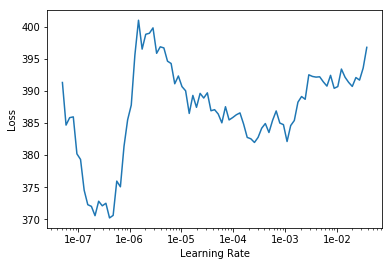

In [0]:
learn.recorder.plot()

The paper uses a learning rate of `1e-5` to train the end-to-end network, but from the plot above, that looks too noisy for me. I'll switch to `1e-7` and make sure to nicely warm up the network by having the learning rate peak at only 60% of the learning cycle.

In [0]:
learn.fit_one_cycle(10, 1e-7, pct_start=0.6)

epoch,train_loss,valid_loss,mse_metric,sad,time
0,383.102570,336.446503,0.000982,336.351379,16:12
1,390.030762,333.555573,0.000964,333.460388,16:09
2,373.072601,332.868530,0.000958,332.773407,16:09
3,392.767395,333.894806,0.000966,333.799652,16:09
4,385.418640,334.092712,0.000968,333.997437,16:09
5,383.302216,335.424469,0.000973,335.329254,16:12
6,387.764496,333.887512,0.000966,333.792297,16:12
7,387.591125,331.172180,0.000950,331.076874,16:11


Buffered data was truncated after reaching the output size limit.

We're not winning a whole lot with this end-to-end training, the individual parts are already well-trained. Loss only drops from `336` to `331`. I'll take it, but it's not a world of difference.

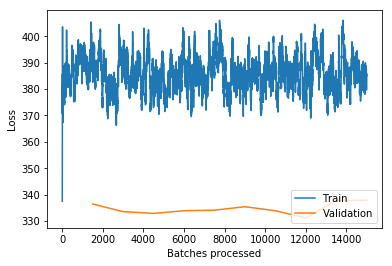

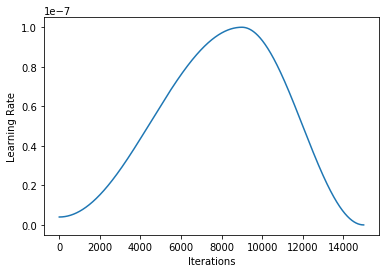

In [0]:
learn.recorder.plot_losses()
learn.recorder.plot_lr()

So let's take a look at our final performance on the validation set.

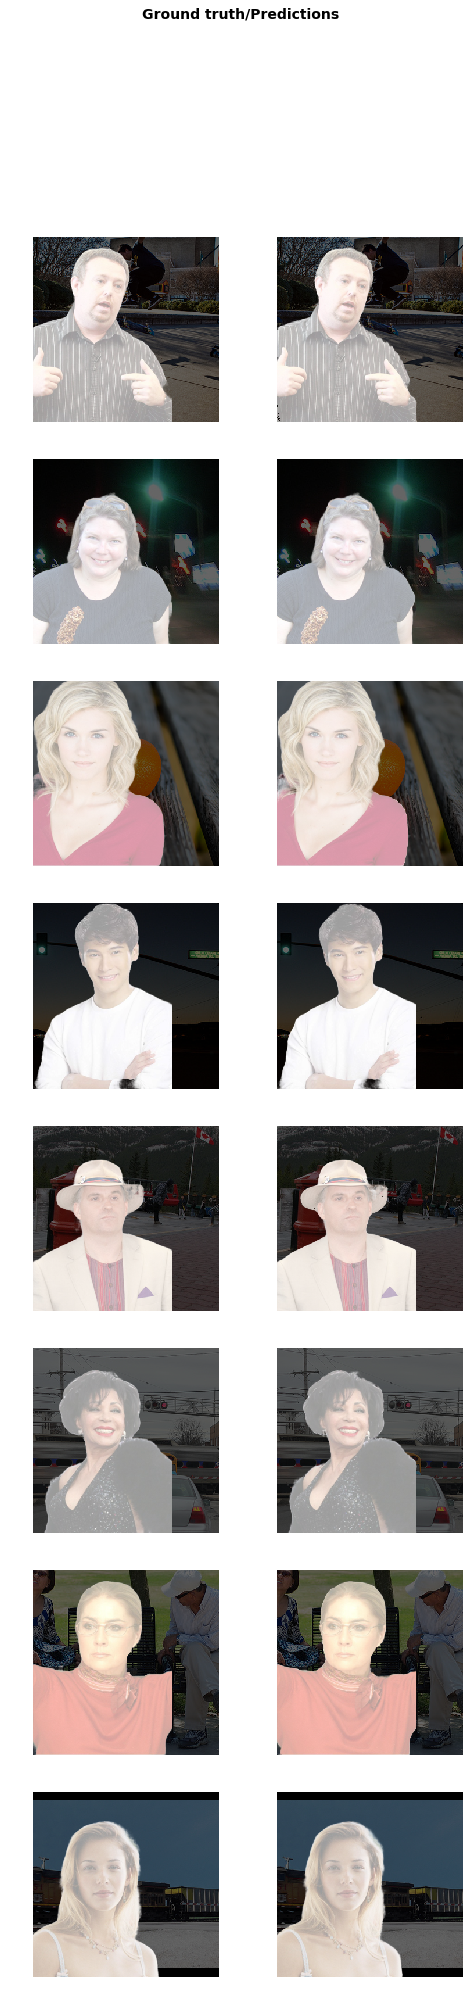

In [0]:
learn.show_results(rows=10)

Pretty decent! It's definitely not perfect, the model still prefers to predict "fuzzy areas" versus nicely detailed hair strands (this is most clearly visible in the last image) but all in all it looks like a decent matting. We'll save these weights for later use.

In [0]:
learn.save('e2e-frozen', return_path=True)

PosixPath('/content/gdrive/My Drive/fastai-files/aisegment/test3/320/patch/models/e2e-frozen.pth')

In [0]:
_ = learn.load('e2e-frozen')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


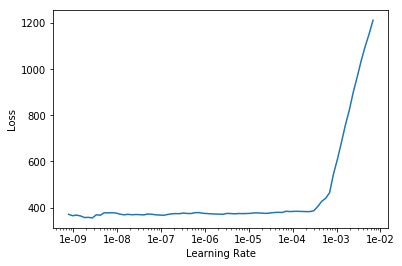

In [0]:
learn.wd = 1e-1
learn.unfreeze()
learn.lr_find(start_lr=1e-10, end_lr=1e-1)
learn.recorder.plot()

We already didn't win a whole lot by training end-to-end, and it doesn't look like unfreezing the model is going to get us anything at all performance wise (loss is a complete plateau across orders of magnitude of the learning rate). We'll stop here.

# Results: Applying to CelebA
So we have CelebA trimaps from the previous part, and we now have a model that turns trimaps into alpha mattes! Let's see how it fares on the CelebA samples I pulled.


In [0]:
# Setting up the skeleton
learn = custom_dim_learner(data, 
                           resnet34, 
                           metrics=metrics, 
                           callbacks=[ConcatAlphaOnEval()], 
                           split_on=dim_e2e_split, 
                           y_range=(0., 1.))

learn.model.training = False

In [0]:
_ = learn.load('e2e-frozen')

Note that here, the trimaps are already on the A-channel of the inputs, so I won't need any transforms.

In [0]:
filesize = 320
images_path = Path(f"{data_dir}/{filesize}/patch")

src = (DIMImageList.from_folder(images_path, convert_mode='RGBA')
      .split_by_rand_pct(0.2, 42)
      .label_from_func(get_y_fname)
      )

items = src.x.__class__.from_folder(f"{data_dir}/celeba-sample/rgb-trimap", convert_mode='RGBA')
src = src.add_test(items.items, label=None)

bs = 8 # batch size
data = (src.transform(([], []), tfm_y=True)
        .databunch(bs=bs)
        .normalize(modified_imagenet_stats))

data.c = 1

learn.data = data

I'll plot the original image, the predicted trimap, the predicted alpha and the resulting composition to get a feeling of the process.

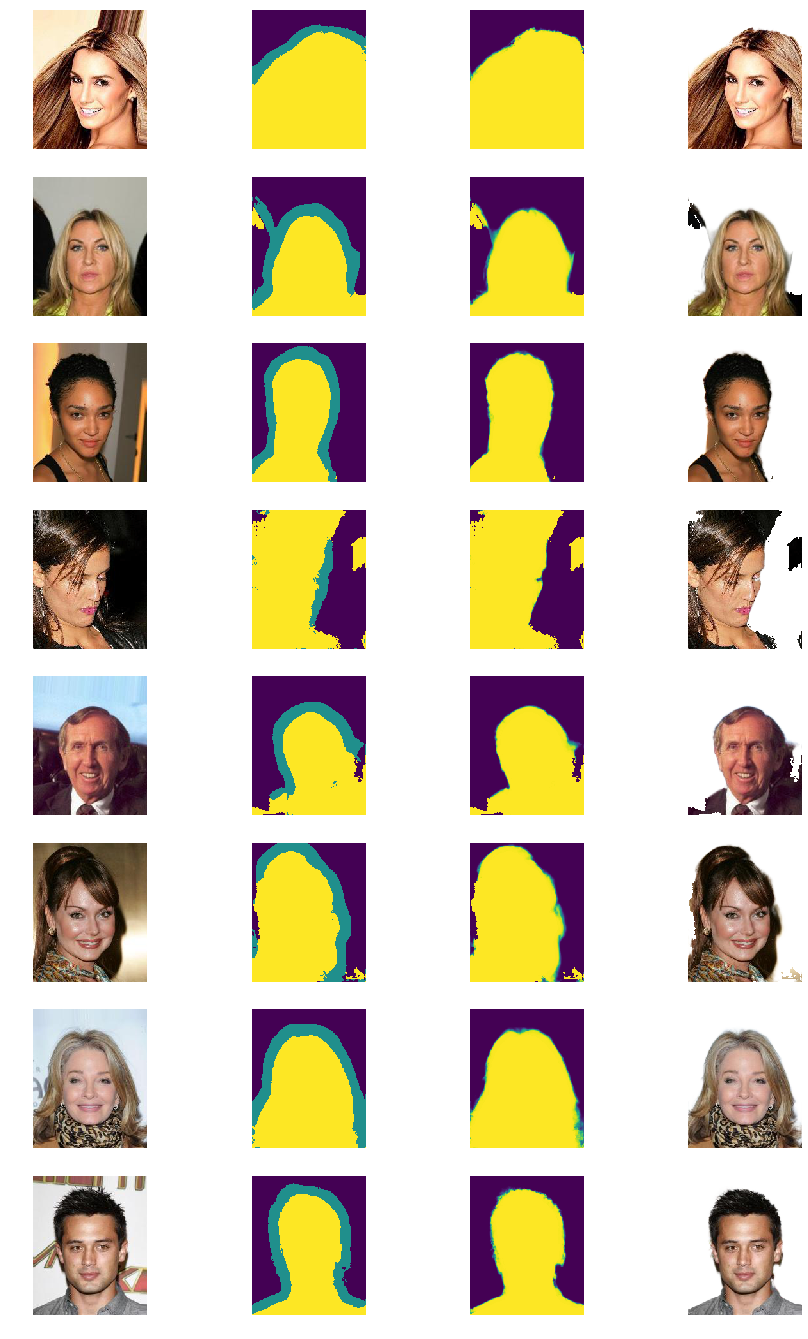

In [142]:
figure_size = 10
num_img = 8

for idx, (inputs, targs) in enumerate(learn.data.test_dl):

    inputs[:,3:4,:] = inputs[:,3:4,:]*255
    inputs[:,3,:][inputs[:,3,:] == 1.] = 0.5
    inputs[:,3,:][inputs[:,3,:] == 2.] = 1.
    trimaps = inputs[:,3:4,:]
    assert(np.array_equal(np.unique(inputs[:,3,:].detach().cpu().numpy()), np.array([0., 0.5, 1.])))
    
    mean, std = torch.tensor([0.485, 0.456, 0.406, 0]).cpu(), torch.tensor([0.229, 0.224, 0.225, 0]).cpu()
    alphas = learn.pred_batch(batch=(inputs, targs))
    
    inputs = inputs.cpu()
    # denorm
    inputs = inputs * std[..., None, None] + mean[:, None, None]
    bs = inputs.shape[0]
    
    f, ax = plt.subplots(num_img, 4)
    
    f.set_figheight(3*num_img)
    f.set_figwidth(15)
    
    for batch_num in range(bs):

        alpha = image2np(alphas[batch_num] * 255)
        patch = image2np(inputs[batch_num,:][0:3] * 255).astype(np.uint8)
        trimap = image2np(trimaps[batch_num]*255).astype(np.uint8)
        
        patch = PIL.Image.fromarray(patch)
        alpha = PIL.Image.fromarray(alpha).convert('L')
        trimap = PIL.Image.fromarray(trimap).convert('L')

        
        ax[batch_num, 0].imshow(patch)
        ax[batch_num, 0].axis('off')
        
        ax[batch_num, 1].imshow(trimap)
        ax[batch_num, 1].axis('off')
        
        ax[batch_num, 2].imshow(alpha)
        ax[batch_num, 2].axis('off')
        
        patch.putalpha(alpha)
        ax[batch_num, 3].imshow(patch)
        ax[batch_num, 3].axis('off')
        
        if batch_num == num_img-1:
            break
        
    break

That's... okay-ish/disappointing? Let's step through what we're seeing here:
* **The trimaps are a tragedy.** The biggest performance loss currently is clearly due to the poor trimaps. I would've expected the complex part of this challenge would be the DIM network. Turns out it's the trimap generator. That definitely needs more work, though I'm not sure how to improve it. Shadows and low-contrast areas are clearly very challenging (see rows 6 and 8).
* **Where trimaps aren't terrible, the network does pretty decently.** Taking a look at the second-to-last row, where the trimap seems to have worked out, the network nicely preserves the hair strands on the right side of the image. Satisfying outcome!
* **The network doesn't maintain "spiky" details very well.** Looking at the last row of images, our friend got a serious haircut. They clearly have "spiky" hair that's nicely visible on the white background, but we see that our alpha mat kind of "smoothes" this out. The mat still looks decent (if we don't look at the ears, I think it's getting confused because of the shadow) but detail is lost.

# Closing thoughts
I wanted to jot down some ideas on how I could further improve the network/pipeline detailed above:
* **Better trimaps.** The immediate take-away from the performance analysis above is that the trimaps were of pretty tragic quality. I'll have to think more about how I want to solve this, though of course one way could be by hand-crafting the trimaps. Given the CelebA dataset is 200k images, that doesn't sound very appealing though. Not sure what alternatives could be.
* **Better data.** I think this is a pretty big one. The AISegment dataset I used is nice, but it's not exactly perfect input for training purposes. Going through the dataset you'll notice there's quite a few areas of imperfection (odd alpha irregularities, too coarse/jagged for hair strands etc).
* **More backgrounds.** I've used the validation COCO dataset with images that have the COCO supercategory "outdoor" (that seemed the most relevant to a CelebA dataset) to generate the image patches on which to train. There's only ~1500 of those though, which means they'll get repeated on average 10 times throughout my training datasets. This could lead to overfitting on the background. Using the COCO train set I could probably get more, but I didn't have the space on my Google Drive account.
* **More data.** I've currently ony used 15k out of the \~40k images available in SegmentAI. That's a factor 4, and I think there's still some juice that can be squeezed out of that additional data. I prepared most of this notebook with 1.5k images for speed reasons, going to \~15k improved performance by \~20x on the SAD. However, with Colab's current limitation (~12 hours max uninterrupted GPU usage, slow disk I/O), I'd need access to a bigger/better rig to run experiments and see how much larger the benefit could be.
* **Experiment with different encoders.** Both the DIM paper, as well as the SHM paper, use VGG16 (though they remove the last layer because it has too many parameters and is sensitive to overfitting). This should be relatively easy to implement, at least experimenting with a different encoder architecture (though the layer replacement for 4 channels would have to be reviewed). Other possibilities include ResNet50 etc.
* **Different network architecture.** The Semantic Human Matting paper mentioned above doesn't use trimaps at all. It connects a PSPNet-50 to a U-net and lets the algorithm directly learn how to generate raw alphas without the use of a trimap (i.e. "unassisted"). I stuck to the DIM paper here because I didn't have a pyTorch-ready PSPNet integration lying around, and it seemed like a too big network to casually fit on Colab's GPUs for the end-to-end training phase. I'd be interested in trying it though. I saw some PSPNet pyTorch architectures floating around on GitHub that could be used. It's also worth mentioning the researchers don't seem to insist it should be PSPNet-50. They claim any state of the art segmentation network should suffice, they just chose PSPNet.
* **Developing a vaccine for the measles.** During my initial trimap generation and as shown in the notebook, my initial trimaps seemed to suffer from 'measles'. I suspect I could fix this using a `cv2.filter2D()` but it would take me at least another day to properly implement that into the current architecture, not to mention re-training everything for what I suspect will be a marginal gain. As observed, the trimap network focuses on learning the outlines and seems to ignore these small uncertainty regions.